# Хакатон. Арабы и Катя

### Наши данные - корпус твиттов Трампа.

Импортируем всё необходимое

In [4]:
import collections
from datetime import datetime
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()
from string import punctuation
import nltk
from nltk.corpus import stopwords
stopword_set = set(stopwords.words('russian'))
import numpy as np
import markovify
import re
import spacy

nltk.download('averaged_perceptron_tagger')

spacy.prefer_gpu()

False

Записываем csv-файл в датафрейм

In [5]:
df = pd.read_csv('trumptweets-1515775693.tweets.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (15,30,31,32,36,37,38,42,43,44,45,46,47,50,51,52,56,57,58,59,60,61,62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Количество лайков в зависимости от геолокации

В базу данных записываем нашу таблицу на всякий случай

In [6]:
con = sqlite3.connect('hak.db')

In [7]:
# создаем объект "курсор", которому будем передавать запросы
c = con.cursor()

# сохраняем изменения
con.commit()

In [8]:
df.to_sql(name='tweets', con=con, if_exists='replace')

In [9]:
#сохраняем
con.commit()

Вытаскиваем страны

In [10]:
def places(df):
    countries = []
    for row in c.execute('''SELECT country FROM tweets
                WHERE country is not NULL'''):
        if row[0] not in countries:
            countries.append(row[0])
    return countries
countries = places(df)

Создаём датафрейм для графика

In [11]:
def to_df(countries):
    g_t = []
    for country in countries:
        x = (country, )
        for row in c.execute('''SELECT country, favorite_count FROM tweets
                    WHERE country=?''', x):
                        d = {}
                        d['country'] = row[0]
                        d['likes'] = row[-1]
                        g_t.append(d)
    df_sl = pd.DataFrame(g_t)
    return df_sl
df_sl = to_df(countries)

Закрываем базу данных

In [12]:
con.close()

Строим график

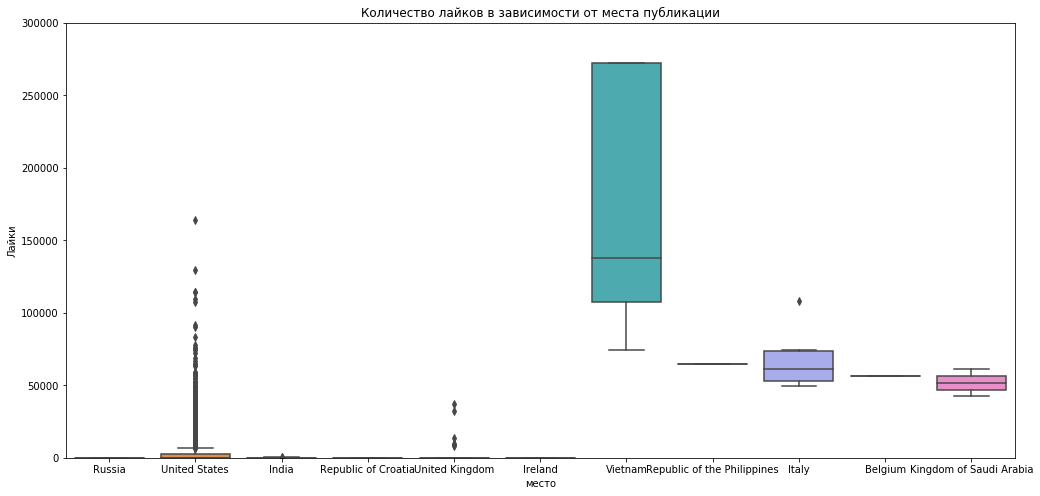

In [13]:
plt.figure(figsize=(17,8))
sns.boxplot(x='country', y='likes', data=df_sl)
plt.ylim((0, 300000))
plt.title('Количество лайков в зависимости от места публикации')
plt.ylabel('Лайки')
plt.xlabel('место');

### Теперь вордклауд и марковская цепь

Это класс *POSifiedText(markovify.Text)*, который нужен для улучшения качества работы марковской цепи за счёт модуля *nltk*. Он предлагается в документации *markovify*.

In [14]:
class POSifiedText(markovify.Text):
    def word_split(self, sentence):
        words = re.split(self.word_split_pattern, sentence)
        words = [ "::".join(tag) for tag in nltk.pos_tag(words) ]
        return words

    def word_join(self, words):
        sentence = " ".join(word.split("::")[0] for word in words)
        return sentence

В этой функции производится лёгкий препроцессинг данных для загрузки в модель. Затем происходит обучение модули. После этого модель записывается в файл mark_model_trump.json.

In [15]:
def mod(df):
    text = df['text'].dropna().values.tolist()
    new_text = []
    for t in text:
        t = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', t, flags=re.MULTILINE)
        t = re.sub(r'\b#\w+?\b', '', t, flags=re.MULTILINE)
        new_text.append(t)
    text_str = ' '.join(new_text)
    text_model = POSifiedText(text_str, state_size=2)
    model_json = text_model.to_json()
    with open('mark_model_trump.json', 'w') as f:
        f.write(model_json)

Здесь модель используется. Генерируется 15 предложений, состоящих не более, чем из 250 символов.

In [16]:
def model_use():
    model_json = open('mark_model_trump.json').read()
    model = POSifiedText.from_json(model_json)
    for i in range(15):
        print(model.make_short_sentence(250))

Здесь создаётся облако хэштэгов в форме круга.

In [17]:
def w_cloud(df):
    tags = df['hashtags'].dropna().values.tolist()
    tags_string = ' '.join(tags)
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    wordcloud = WordCloud(mode = "RGBA", width = 1000, height = 1000, collocations=False, mask=mask,
                         background_color='white').generate(tags_string)
    plt.figure(figsize = (6, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [20]:
mod(df)

In [21]:
model_use()

The real estate assets in the history of the ADMINISTRATION - healthcare, spying, NSA, IRS, brutally killed Americans -WILL IT EVER END?
Watch Miss USA . Check out today's #trumpvlog about the costly, bird killing wind turbines!
Great optimism in America today.
Great POLL numbers are down big.
The NYC casting call for comment or clarification before writing an editorial which is “cooler”—my induction into the Trans-Pacific Partnership.
Looking forward to speaking @nranews Convention in Myrtle Beach #SCTeaParty15 Entrepreneurs Use your imagination.
The only problem is that I am speechless!
So ridiculous - let me know!
Be sure to check on the solution, not the plane behind her like I do out of office for spending so much to get to 1237 - he is consistent.
.@KarlRove, who spent $430 million in cash going to lose their healthcare by 2020 @BarackObama will not run for president.
Thank you @foxandfriends - great people, great state!
Just as I say, not as it gets.
Time to get people to vote o

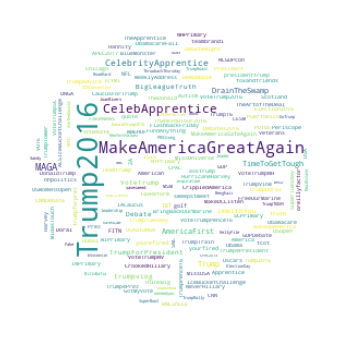

In [22]:
w_cloud(df)

### Упоминания людей и ответы на твиты

Посмотрим, кого Дональд Трамп чаще всего упоминает. Для этого используем метод groupby, переведем все в словарь, а затем сделаем посмотроим на основании него график.

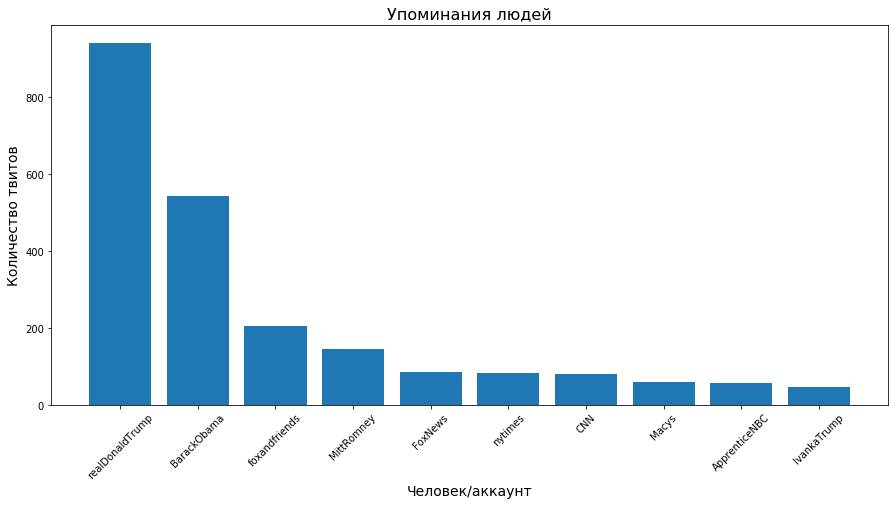

In [23]:
m = df.groupby('mentions_screen_name')['status_id'].nunique().to_dict()
mentions = dict(sorted(m.items(), key=lambda x: x[1], reverse=True)[:10])
keys = mentions.keys()
values = mentions.values()
plt.figure(figsize=(15,7))
plt.bar(keys, values)
plt.xticks(rotation=45)
plt.xlabel('Человек/аккаунт', fontsize=14)
plt.ylabel('Количество твитов', fontsize=14)
plt.title('Упоминания людей', fontsize=16)
plt.show()

Чаще всего Трамп говорит о себе, что несколько неожиданнно. Чуть менее часто упоминается Обама и сопартийник Трампа Митт Ромни. Кроме того, Трамп часто пишет о новостных агенствах, вероятно, борясь с фейкньюс.

Сделаем то же самое для ответов на твиты

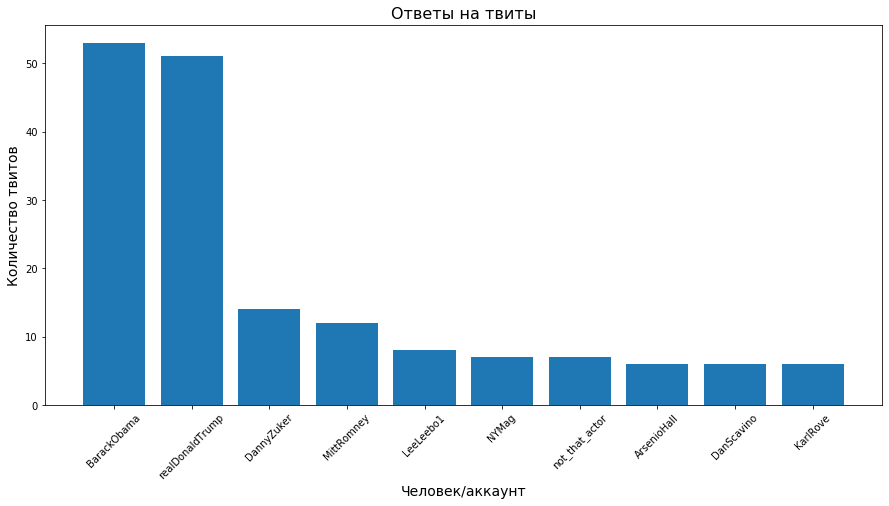

In [24]:
r = df.groupby('reply_to_screen_name')['status_id'].nunique().to_dict()
replies =  dict(sorted(r.items(), key=lambda x: x[1], reverse=True)[:10])
keys = replies.keys()
values = replies.values()
plt.figure(figsize=(15,7))
plt.bar(keys, values)
plt.xticks(rotation=45)
plt.xlabel('Человек/аккаунт', fontsize=14)
plt.ylabel('Количество твитов', fontsize=14)
plt.title('Ответы на твиты', fontsize=16)
plt.show()

Теперь на первое место выходит Барак Обама -- непосредственно с ним Трамп общается чаще всего. Чутть реже Дональд отвечает на собственные твиты. Также президент много общается с простыми людьми, не политиками, например LeeLeeb1 и not_that_actor, которые его поддерживают.

### Популярность Дональда

Посмотрим, сколько Трампа лайкали и репостили в разные периоды его жизни.

Приведем даты к единообразному формату.

In [25]:
from tqdm import tqdm_notebook as tqdm
count = 1
print(df.loc[[count],'created_at'])
for i in tqdm(df['created_at']):
    try:
        i = i.split(' ')[0].split('-')[:2]
        i = ' '.join(i)
        df.loc[[count],'new'] = i
        count += 1
    except:
        pass

1    2010-11-29 15:52:46
Name: created_at, dtype: object


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


С помощью нового столбца с датами построим график, указывающий на количество ретвитов и лайков в разные годы.

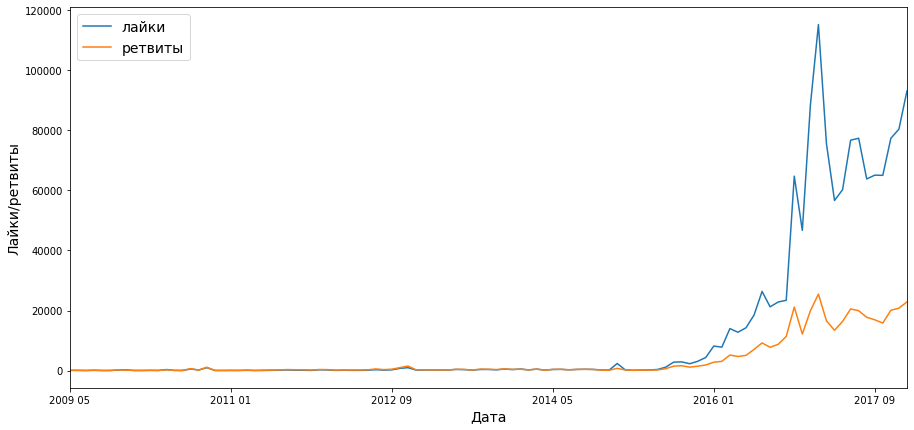

In [26]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby('new')['favorite_count'].mean().plot(ax=ax)
df.groupby('new')['retweet_count'].mean().plot(ax=ax)
ax.legend(['лайки', 'ретвиты'], fontsize=14)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Лайки/ретвиты', fontsize=14)
plt.show()

Что ожидаемо, количество лайков и репостов начинает расти в 2016, когда Трамп заявляет о намерении участвовать в американских выборах. Пик популярности приходится на февраль 2017, когда Трамп попадает в большой скандал из-за одного из своих публичных выступлений и, очевидно, много об этом пишет.

Создадим два словаря: словарь c количеством твитов каждого упоминаемого пользователя и график со всем количеством лайков для твитов с упоминанием каждого пользователя.

In [33]:
def likes():
    list_mentioned = list(df.mentions_screen_name.unique())
    dict_amount = {}
    dict_likes = {}
    for x in list_mentioned:
        counter = 0
        if x != 'nan':
            likes_per_person = df[df.mentions_screen_name == x].favorite_count
            l = list(likes_per_person)
            dict_amount[x] = len(list(l))
            for i in l:
                counter += i
            dict_likes[x] = counter
    return dict_amount, dict_likes

Посчитаем среднее количество лайков по твитам по упоминаемым пользователям.

In [34]:
def medium(dict_amount, dict_likes):
    med_likes = {}
    for key in dict_likes:
        try:
            s = dict_likes[key]/dict_amount[key]
            med_likes[key] = round(s)
        except:
            continue
    a = sorted(med_likes.items(), key=lambda x: x[1], reverse=True)[:15]
    return a

Нарисуем график.

In [35]:
def graph(a):
    nums = [w[-1] for w in a]
    labs = [w[0] for w in a]
    plt.figure(figsize=(20, 10), dpi=200)
    plt.bar(range(len(labs)), nums)

    plt.title('Среднее количество лайков на твитах, в зависимости от упоминаемых пользователей')
    plt.ylabel('Среднее количество лайков')
    plt.xlabel('Упоминаемые пользователи')
    plt.xticks(range(len(labs)), labs, rotation=90)
    #plt.legend()
    plt.show()

In [36]:
likes()

({nan: 0,
  'IvankaTrump': 48,
  'BarackObama': 544,
  'bretmichaels hollyrpeete': 1,
  'kingsthings': 2,
  'FoxNews gretawire BarackObama': 2,
  'Rosie': 21,
  'TIME TIME': 1,
  'Rosie Rosie': 2,
  'BarbaraJWalters ABC': 3,
  'Lawrence': 12,
  'TrumpCollection Travlandleisure TrumpNewYork TrumpLasVegas TrumpChicago': 1,
  'FoxNews': 87,
  'JonHuntsman Lawrence msnbctv Lawrence': 1,
  'EWErickson RedState': 2,
  'AmericansElect': 1,
  'Lawrence Rosie': 1,
  'EricTrump Forbes': 1,
  'JonHuntsman': 9,
  'FoxNews gretawire': 9,
  'timetogettough': 3,
  'ASavageNation': 2,
  'Esquiremag DonaldJTrumpJr': 1,
  'FoxNews TeamCavuto iontv': 2,
  'ralphreed': 4,
  'iontv': 3,
  'Israel': 9,
  'foxandfriends': 205,
  'TeamBachmann iontv': 1,
  'SteveKingIA iontv': 1,
  'MorningJoe JoeNBC morningmika iontv': 1,
  'RickSantorum': 13,
  'KarlRove BarackObama': 1,
  'CNN PiersTonight iontv': 1,
  'SarahPalinUSA iontv': 1,
  'AndrewBreitbart': 2,
  'WOR710 newtgingrich': 1,
  'FoxNews megynkelly iontv

In [38]:
medium(dict_amount, dict_likes)

NameError: name 'dict_amount' is not defined

In [32]:
graph(a)

NameError: name 'a' is not defined

Теперь достенем те твиты, в которых есть слова "russia", "putin", и "moscow".

In [ ]:
def russia(df):
    df['lemmatized'] = df.text.apply(lambda x: ' '.join(morph.parse(w.strip(punctuation))[0].normal_form for w in x.split()))
    rus_tweets = []
    for cell in df['lemmatized'].values:
        if ('russia' in cell) or ('putin' in cell) or ('moscow' in cell):
            rus_tweets.append(cell)
    return rus_tweets

In [ ]:
rus_tweets = russia(df)

In [ ]:
import en_core_web_sm

nlp = en_core_web_sm.load()

Создадим список глаголов, которые встречаются в таких твитах.

In [ ]:
def rus_vbs(rus_tweets):
    s = []
    dict_russia = {}
    rus_verbs = []
    for tweet in rus_tweets:
        doc = nlp(tweet)
        for token in doc:
            a = token.lemma_
            b = token.pos_
            if b == 'VERB':
                s.append(a)
    return s

In [ ]:
s = rus_vbs(rus_tweets)
v_d = dict(Counter(s).most_common(30))

In [ ]:
Построим график топ-30 таких глаголов.

In [ ]:
def graph_2(v_d):
    f_w_nums = [v_d[w] for w in v_d]
    f_w_labs = [w for w in v_d]
    plt.figure(figsize=(20, 10), dpi=200)
    plt.bar(range(len(f_w_labs)), f_w_nums)

    plt.title('Самые популярные глаголы, употребляемые с Россией, Путиным и Москвой')
    plt.ylabel('Количество употреблений')
    plt.xlabel('Глаголы')
    plt.xticks(range(len(f_w_labs)), f_w_labs, rotation=90)
    #plt.legend()
    plt.show()
    

In [ ]:
graph_2(v_d)